In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv("C:\\train.csv")
test = pd.read_csv("C:\\test.csv")
submission = pd.read_csv("C:\\sample_submission.csv")

In [3]:
train.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
test.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [5]:
submission.head()

,id,Calories
0,750000,88.283
1,750001,88.283
2,750002,88.283
3,750003,88.283
4,750004,88.283


In [6]:
train.drop("id", axis=1, inplace=True)
test_ID = test["id"]
test.drop("id", axis=1, inplace=True)

In [7]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

In [8]:
# BMI
train['BMI'] = train['Weight'] / ((train['Height']/100) ** 2)
test['BMI'] = test['Weight'] / ((test['Height']/100) ** 2)

# Workout Intensity
train['Workout_Intensity'] = train['Heart_Rate'] * train['Duration']
test['Workout_Intensity'] = test['Heart_Rate'] * test['Duration']

# Temp-HR Ratio
train['Temp_HR_Ratio'] = train['Body_Temp'] * train['Heart_Rate']
test['Temp_HR_Ratio'] = test['Body_Temp'] * test['Heart_Rate']

# Age Groups
age_bins = [0, 20, 40, 60, 100]
age_labels = [0, 1, 2, 3]
train['Age_Group'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels).astype(int)
test['Age_Group'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels).astype(int)



In [9]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Temp_HR_Ratio,Age_Group
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,2626.0,4141.0,1
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,680.0,3374.5,3
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,588.0,3343.2,2
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,2625.0,4273.5,0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,2550.0,4141.2,1


In [10]:
print("Checking for missing values...")
print(train.isnull().sum())
print(test.isnull().sum())

Checking for missing values...
Sex                  0
Age                  0
Height               0
Weight               0
Duration             0
Heart_Rate           0
Body_Temp            0
Calories             0
BMI                  0
Workout_Intensity    0
Temp_HR_Ratio        0
Age_Group            0
dtype: int64
Sex                  0
Age                  0
Height               0
Weight               0
Duration             0
Heart_Rate           0
Body_Temp            0
BMI                  0
Workout_Intensity    0
Temp_HR_Ratio        0
Age_Group            0
dtype: int64


In [11]:
target_corr = train.corr()['Calories'].sort_values(ascending=False)
print(target_corr)


Calories             1.000000
Workout_Intensity    0.977341
Duration             0.959908
Temp_HR_Ratio        0.924599
Heart_Rate           0.908748
Body_Temp            0.828671
Age                  0.145683
Age_Group            0.141307
BMI                  0.049226
Weight               0.015863
Sex                  0.012011
Height              -0.004026
Name: Calories, dtype: float64


In [12]:
X = train.drop('Calories', axis=1)
y = train['Calories']


In [13]:
y_log = np.log1p(y)


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test)

In [15]:
xgb = XGBRegressor(random_state=42)


In [16]:
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.03, 0.1),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}


In [17]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',  # proxy for RMSLE
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1  # prevents freezing
)


In [18]:
random_search.fit(X_scaled, y_log)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A6735CA210>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A673CC7FD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A6734D4090>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A6736BAD50>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [19]:
best_model = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)



Best Parameters: {'colsample_bytree': np.float64(0.8749080237694725), 'learning_rate': np.float64(0.12507143064099163), 'max_depth': 5, 'n_estimators': 121, 'subsample': np.float64(0.9197316968394074)}


In [20]:
train_preds_log = best_model.predict(X_scaled)
train_preds = np.expm1(train_preds_log)


In [21]:
rmsle = np.sqrt(mean_squared_log_error(y, train_preds))
print(f"\nTrain RMSLE: {rmsle:.4f}")


Train RMSLE: 0.0604


In [22]:
test_preds = np.expm1(best_model.predict(X_test_scaled))


In [24]:
# Assign predicted values to the 'Calories' column
submission['Calories'] = test_preds

# Save the updated submission file
submission.to_csv(r'C:\Users\sakshi\submission.csv', index=False)
print("Saved Submission.csv with id and Calories.")

Saved Submission.csv with id and Calories.


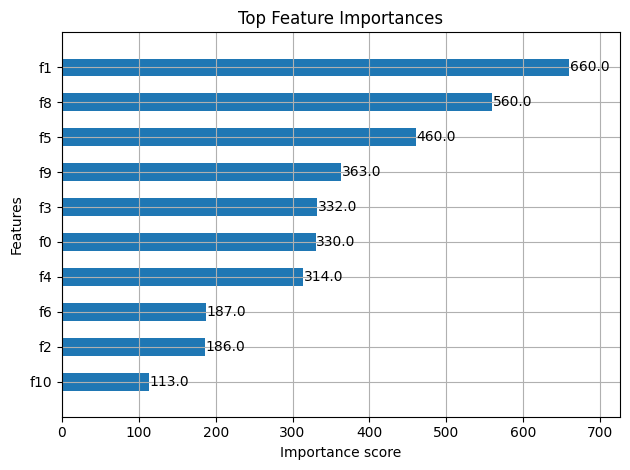

In [25]:
plot_importance(best_model, max_num_features=10, height=0.5)
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


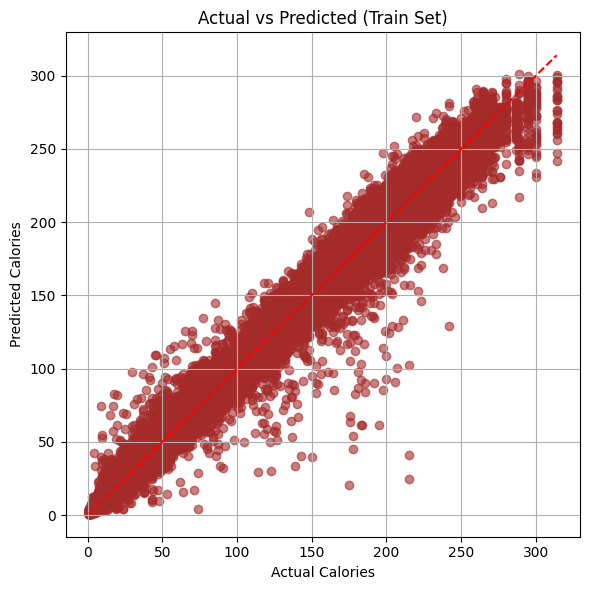

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_log), train_preds, alpha=0.6, color='Brown')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted (Train Set)")
plt.grid(True)
plt.tight_layout()
plt.show()
